# 1. Import the needed libraries

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from math import ceil

# data partition
from sklearn.model_selection import train_test_split,GridSearchCV,RepeatedStratifiedKFold,cross_val_score
# data scaling
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,FunctionTransformer,Binarizer,PowerTransformer,QuantileTransformer
#outliers
from sklearn.ensemble import IsolationForest

#Feature selection
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.feature_selection import RFE

# embedded methods
from sklearn.linear_model import LassoCV

# Model selection
from sklearn.model_selection import StratifiedKFold,RepeatedKFold,train_test_split, cross_val_score,GridSearchCV

#OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,GradientBoostingClassifier,StackingClassifier,AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_curve
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 2. Import data

In [25]:
#creates a dataframe from the csv file "train"
df = pd.read_csv("train.csv")
df.head()

,Access_ID,Date,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy
0,102863333,21-Mar-20,0,0.0,0,0.0,3,64.0000,0.0000,0.0667,0.0000,MacOSX,2,Portugal,1,Returner,0
1,103117814,20-May-20,0,0.0,0,0.0,23,684.5000,0.0217,0.0449,0.0000,Windows,2,France,6,Returner,0
2,103201891,4-Dec-20,0,0.0,0,0.0,8,95.0000,0.0250,0.0583,0.0000,Windows,4,Italy,1,Returner,0
3,103226087,22-Dec-20,0,0.0,0,0.0,9,608.7500,0.0000,0.0250,42.4225,Windows,2,United Kingdom,2,Returner,1
4,103234445,24-Nov-20,0,0.0,2,386.0,36,1609.9397,0.0000,0.0093,12.5033,Windows,2,Spain,3,Returner,1


# 3. Explore the data

In [26]:
#Prints all the important information about our features and the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Access_ID                   9999 non-null   int64  
 1   Date                        9999 non-null   object 
 2   AccountMng_Pages            9999 non-null   int64  
 3   AccountMng_Duration         9999 non-null   float64
 4   FAQ_Pages                   9999 non-null   int64  
 5   FAQ_Duration                9999 non-null   float64
 6   Product_Pages               9999 non-null   int64  
 7   Product_Duration            9999 non-null   float64
 8   GoogleAnalytics_BounceRate  9999 non-null   float64
 9   GoogleAnalytics_ExitRate    9999 non-null   float64
 10  GoogleAnalytics_PageValue   9999 non-null   float64
 11  OS                          9999 non-null   object 
 12  Browser                     9999 non-null   int64  
 13  Country                     9999 

In [27]:
#check the duplicated data
df.duplicated().value_counts()

False    9999
dtype: int64

In [28]:
#check the quantity of 0 in data
(df[df.columns] == 0).sum()

Access_ID                        0
Date                             0
AccountMng_Pages              4672
AccountMng_Duration           4785
FAQ_Pages                     7854
FAQ_Duration                  8030
Product_Pages                   33
Product_Duration               628
GoogleAnalytics_BounceRate    4471
GoogleAnalytics_ExitRate        61
GoogleAnalytics_PageValue     7766
OS                               0
Browser                          0
Country                          0
Type_of_Traffic                  0
Type_of_Visitor                  0
Buy                           8447
dtype: int64

# 4. Modify the data

In [29]:
#created a new data for modifying
dfm = df.copy()

In [30]:
dfm['Buy'] = dfm['Buy'].replace([0,1],[False,True])

In [31]:
#change the date to panda datetime
dfm["Date"]= pd.to_datetime(dfm["Date"])
#creat Month column 
dfm["Month"] = dfm["Date"].dt.month_name()
#creat weekday column and replace the number by sign
dfm["weekday"] = dfm["Date"].dt.dayofweek
dfm['weekday'] = dfm['weekday'].replace([0,1,2,3,4,5,6], ['m','t','w','T','f','s','S'])
#drop the Date Column
dfm = dfm.drop(columns="Date")

In [32]:
#set the index
dfm.set_index("Access_ID",inplace=True)

In [33]:
# Replace the number in 'Browser' to make it more categorical
dfm['Browser'] = dfm['Browser'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13], ['a','b','c','d','e','f','g','h','i','j','k','l','m'])

In [34]:
# Replace the number in 'Type_of_Traffic' to make it more categorical
dfm['Type_of_Traffic'] = dfm['Type_of_Traffic'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o'])

In [35]:
#Define metric and non-metric features. 
categorical = dfm.select_dtypes(include="object").columns.to_list()
numerical = dfm.columns.drop(categorical).drop('Buy').to_list()

In [36]:
#remove outliers
iso = IsolationForest(contamination=0.005)
iso_df = iso.fit_predict(dfm[numerical])
mask_out =iso_df == -1
outliers_if=dfm[mask_out]
dfm.drop(outliers_if.index,inplace=True)
print('Percentage of data removed after outliers:',
      np.round(1 -  np.round(dfm.shape[0] / df.shape[0], 5), 5)*100, "%")

Percentage of data removed after outliers: 0.5 %


In [37]:
#transform the numerical data
dfm_num = dfm.select_dtypes(exclude=['object','bool']).set_index(dfm.index)
scaler =RobustScaler().fit(dfm_num)
dfm_num_scaled = scaler.transform(dfm_num) # this will return an array
# Convert the array to a pandas dataframe
dfm_num_scaled = pd.DataFrame(dfm_num_scaled, columns = dfm_num.columns).set_index(dfm.index)
dfm= dfm_num_scaled.join(dfm.select_dtypes(include=['object','bool']).set_index(dfm.index))

# Visual Exploration data modifications

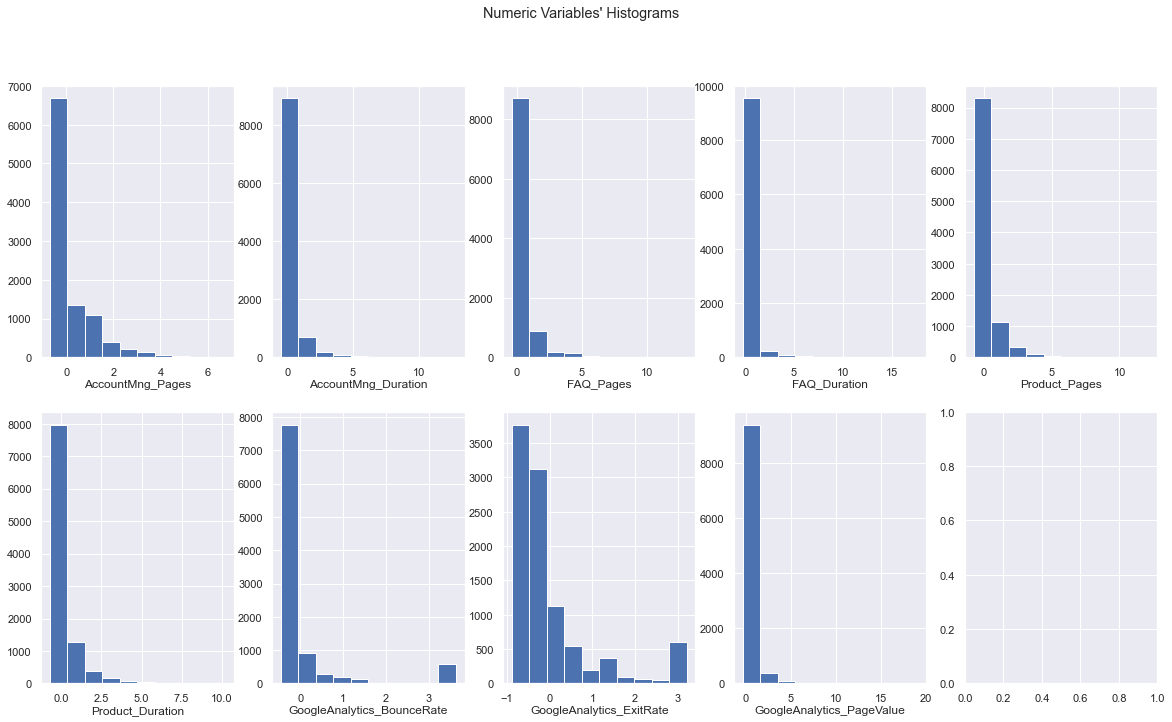

In [15]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(numerical) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), numerical): # Notice the zip() function and flatten() method
    ax.hist(dfm[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

plt.suptitle(title)

plt.show()

Text(0.5, 0.98, "Numeric Variables' Box Plots")

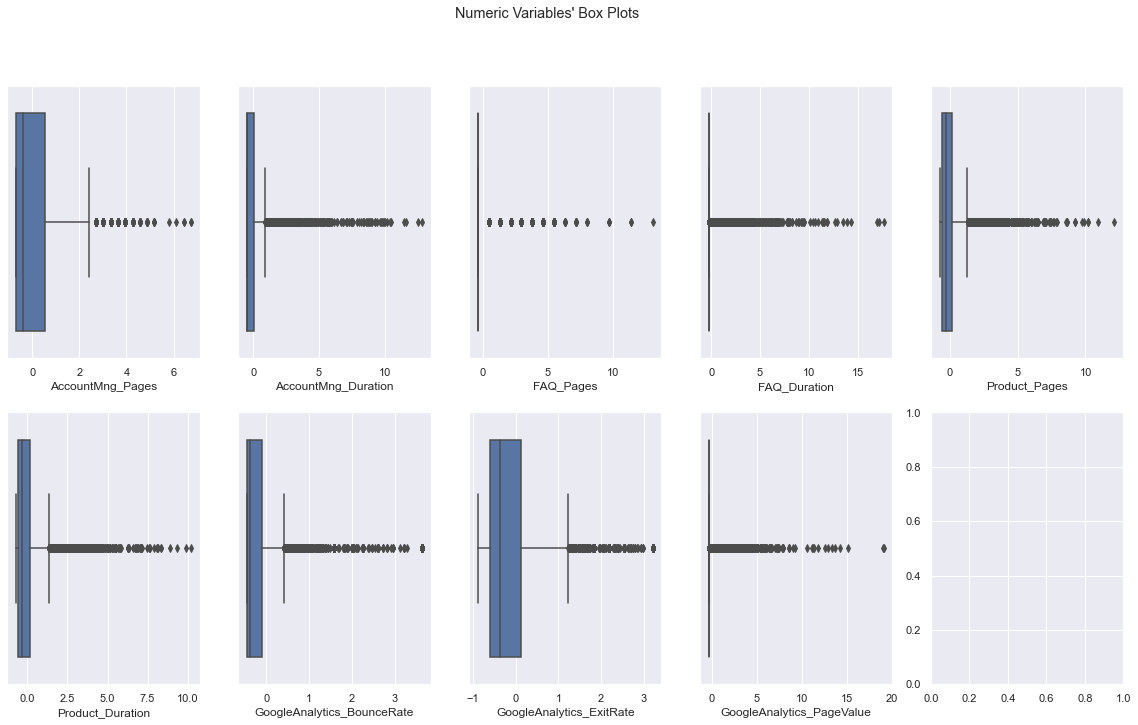

In [16]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(numerical) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), numerical): # Notice the zip() function and flatten() method
    sns.boxplot(x=dfm[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

Text(0.5, 0.98, "Categorical/Low Cardinality Variables' Absolute Frequencies")

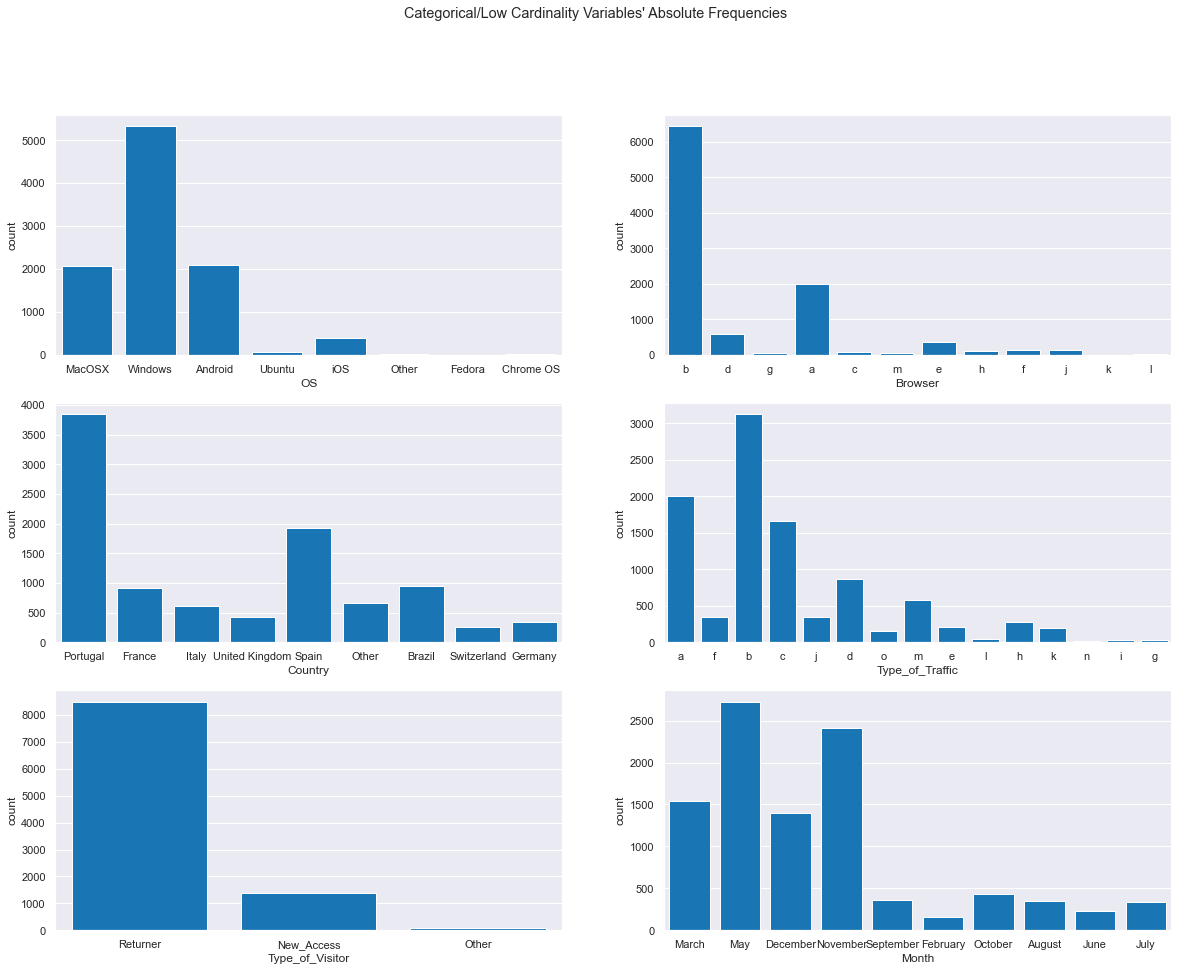

In [17]:
# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(3, ceil(len(categorical) / 4), figsize=(20, 15))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), categorical): # Notice the zip() function and flatten() method
    sns.countplot(dfm[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

Comparing categorical variables with Target column 'Buy'

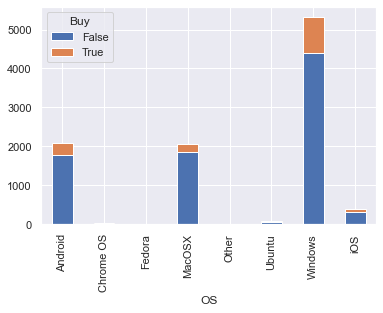

In [18]:
#Comparing 'OS' with Target column 'Buy'
sns.set()
df_counts = dfm\
    .groupby(['OS', 'Buy'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)

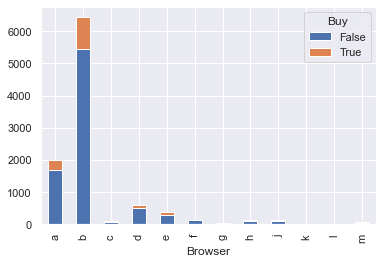

In [19]:
#Comparing 'Browser' with Target column 'Buy'
sns.set()
df_counts = dfm\
    .groupby(['Browser', 'Buy'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)

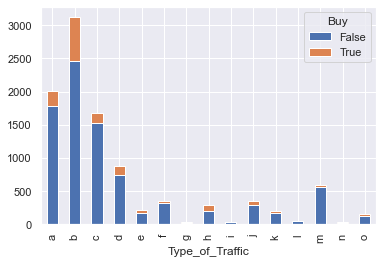

In [20]:
#Comparing 'Type_of_Traffic' with Target column 'Buy'
sns.set()
df_counts = dfm\
    .groupby(['Type_of_Traffic', 'Buy'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)

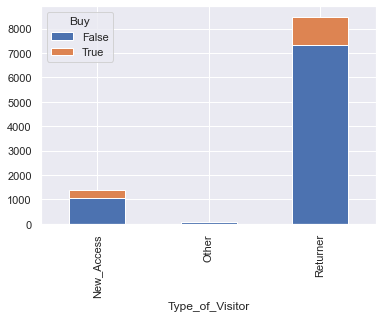

In [21]:
#Comparing 'Type_of_Visitor' with Target column 'Buy'
sns.set()
df_counts = dfm\
    .groupby(['Type_of_Visitor', 'Buy'])\
    .size()\
    .unstack()\
    .plot.bar(stacked=True)

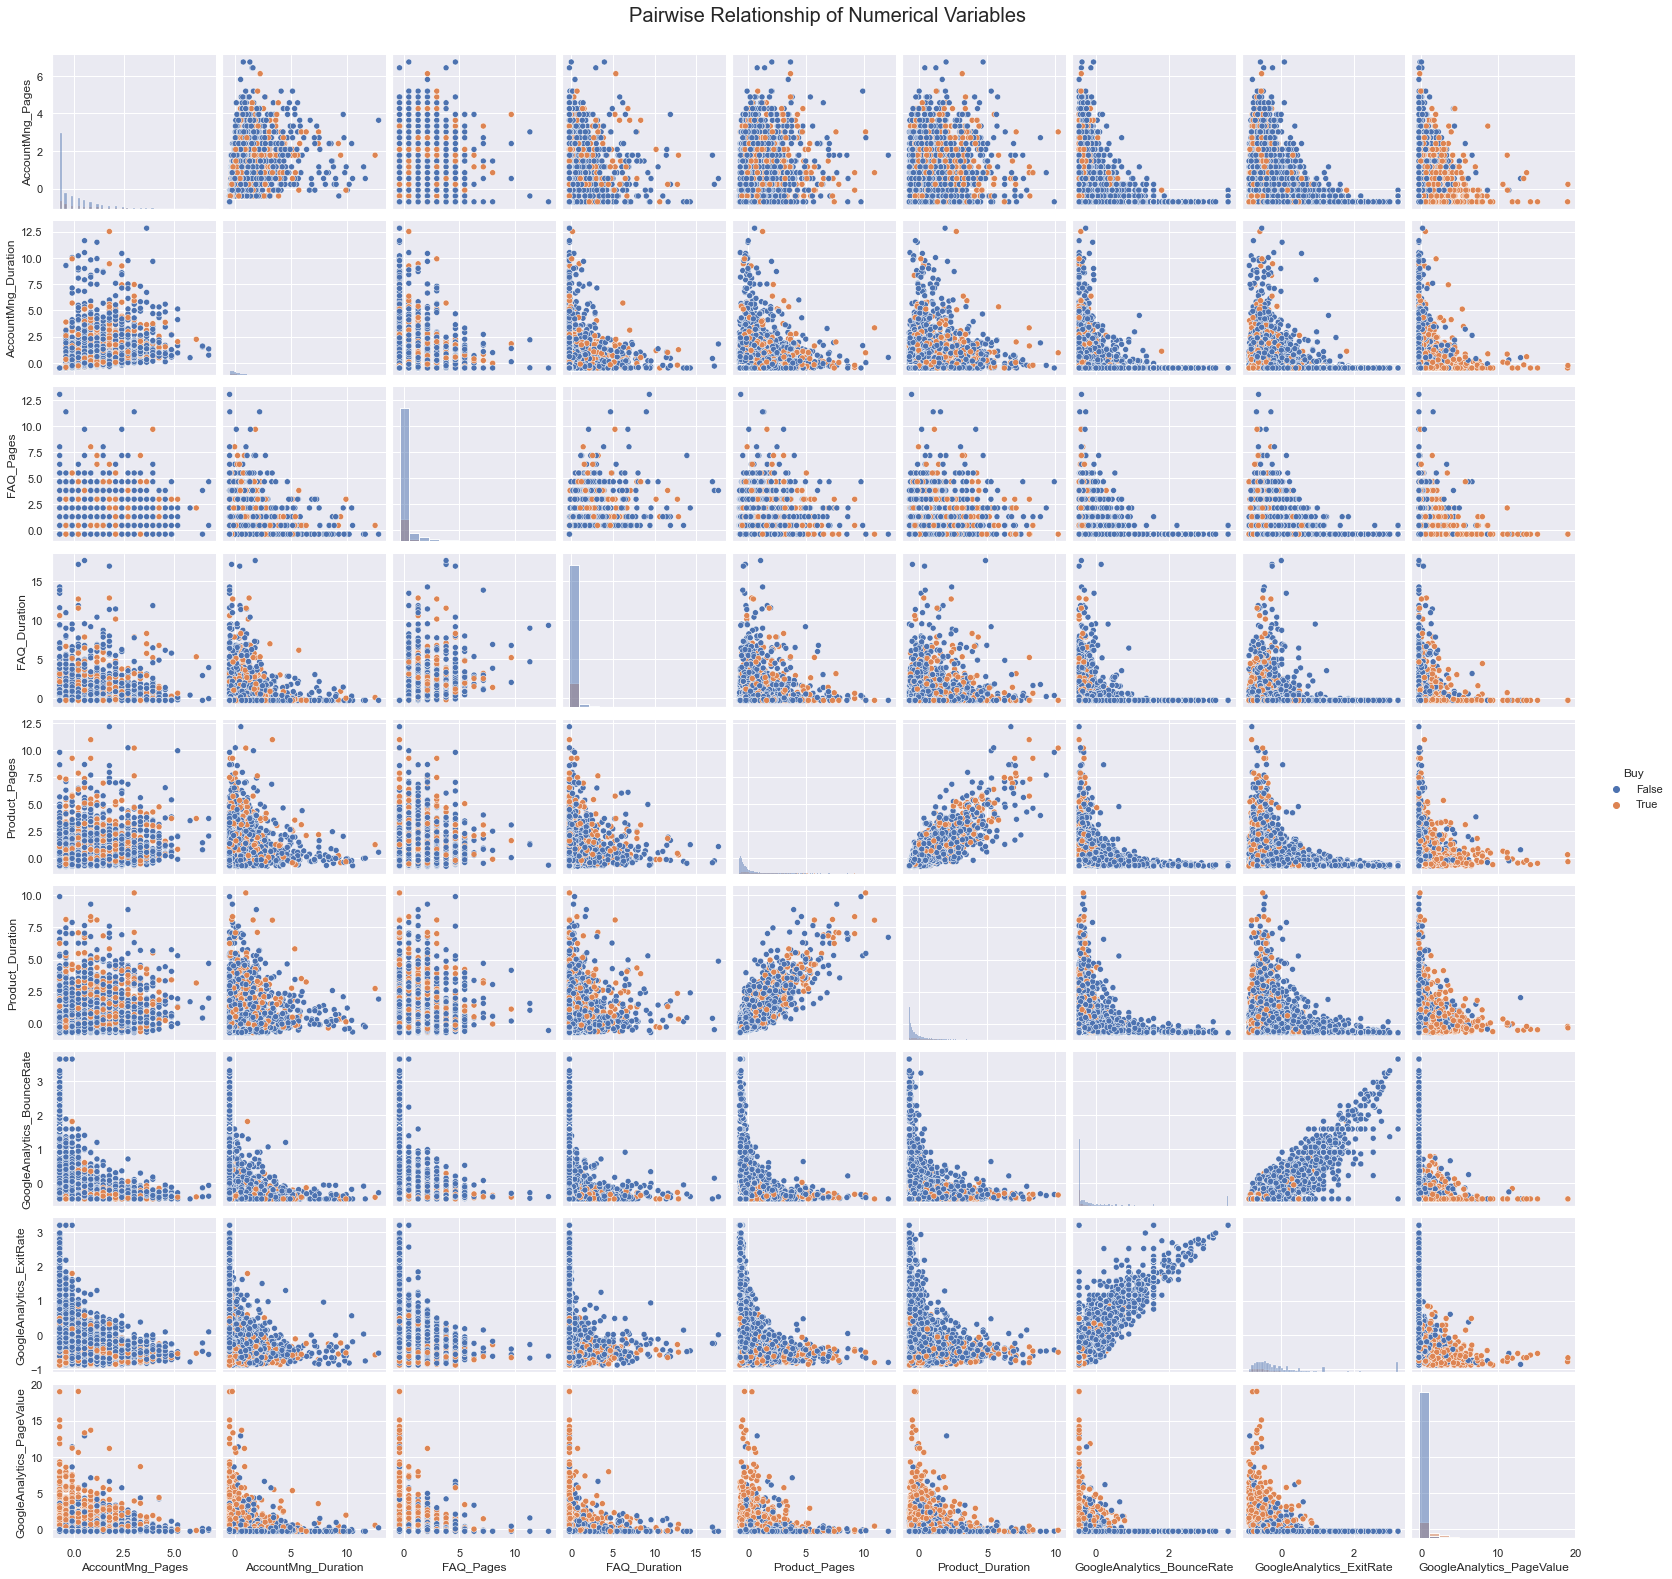

In [22]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(dfm[numerical + ['Buy']], diag_kind="hist", hue='Buy')

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

# Feature Engineering

In [23]:
# Define the independent variables as X and the dependent variable ('Buy') as y.
X = dfm.drop('Buy', axis = 1)
y = dfm['Buy']

In [24]:
X_num = X.select_dtypes(exclude='object').set_index(X.index)
X_cat = X.select_dtypes(include='object').set_index(X.index)
X_num.head(3)

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue
Access_ID,,,,,,,,,
102863333,-0.702926,-0.47746,-0.403515,-0.249511,-0.687833,-0.671953,-0.457828,0.478467,-0.317367
103117814,-0.702926,-0.47746,-0.403515,-0.249511,-0.189858,-0.286188,-0.013895,0.032932,-0.317367
103201891,-0.702926,-0.47746,-0.403515,-0.249511,-0.563340,-0.652680,0.053616,0.306793,-0.317367


 We are going to check now the spearman correlation between the variables. First we need to create a new dataframe with all the training data, but containing also the dependent variable, so we can check if any of the independent variables are correlated with the target. Name this new dataframe as `all_num`. 

In [25]:
all_num = X_num.join(y)
all_num.head()

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Buy
Access_ID,,,,,,,,,,
102863333,-0.702926,-0.47746,-0.403515,-0.249511,-0.687833,-0.671953,-0.457828,0.478467,-0.317367,False
103117814,-0.702926,-0.47746,-0.403515,-0.249511,-0.189858,-0.286188,-0.013895,0.032932,-0.317367,False
103201891,-0.702926,-0.47746,-0.403515,-0.249511,-0.563340,-0.652680,0.053616,0.306793,-0.317367,False
103226087,-0.702926,-0.47746,-0.403515,-0.249511,-0.538441,-0.333282,-0.457828,-0.373772,1.952048,True
103234445,-0.702926,-0.47746,1.278686,2.812372,0.133826,0.289157,-0.457828,-0.694639,0.351504,True


Create a function to plot the correlation between the variables named `cor_heatmap()` that should take as parameters the correlation table `cor`. Define the following conditions in the function:
- the size of the figure should be (12,10)
- create a heatmap using seaborn package where: 
    - `data` should be equal to the correlation table
    - `annot = True`
    - `cmap = plt.cm.Reds`
    - `fmt='.1'`

In [26]:
#Create a function that plots the correlation matrix
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

Check the spearman correlation of the __all_train__ dataset by applying the method `corr()` and assign it to the object `cor_spearman`

Call the function `cor_heatmap()` to the correlation table `cor_spearman`

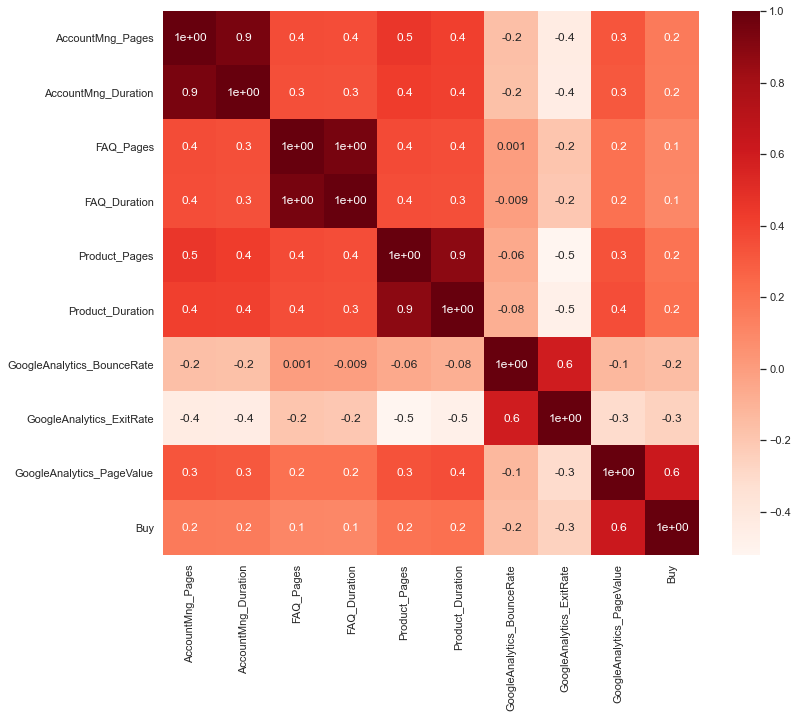

In [27]:
cor_spearman = all_num.corr(method ='spearman')
cor_heatmap(cor_spearman)

#### Through the analysis of the Correlation Matrix some of the variables will be removed. Whenever two varaibles have a correlation equal to 0.9 or higher, it means that these two variables are transmitting practically the same information and one should be removed. Thus, we removed "Product_Pages" and "FAQ_Duration", keeping "Product_Duration" and "FAQ_Pages"
#  
#  

# RFE

This time we are going to apply Recursive Feature Elimination (RFE / Backwards) that will allow to select the most important features to keep. The base estimator used will be a Logistic Regression.

In [28]:
# Using LogisticRegression, create a Logistic Regression Classifier instance called model
model = LogisticRegression()

# Using RFE, create a RFE instance called `rfe` and initialize by defining the following parameters:
# `estimator` = model
# `n_features_to_select` = 2
rfe = RFE(estimator = model, n_features_to_select = 6)
# Transform the data using RFE by applying the method fit_transform() to the instance rfe, 
# where X should be assigned to your independent variables and y to the dependent variable and assign it to the object X_rfe
X_rfe = rfe.fit_transform(X = X_num, y = y)
#Check the variables that were selected by RFE as the most "important" ones by calling the attribute support_ to rfe
X_num.columns

Index(['AccountMng_Pages', 'AccountMng_Duration', 'FAQ_Pages', 'FAQ_Duration',
       'Product_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate',
       'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue'],
      dtype='object')

In [29]:
# Create an object (pandas Series) named selected_features that will have as index the X_train_num columns names 
# and the support_ attribute as value.
selected_features = pd.Series(rfe.support_, index = X_num.columns)
selected_features

AccountMng_Pages              False
AccountMng_Duration           False
FAQ_Pages                     False
FAQ_Duration                   True
Product_Pages                  True
Product_Duration               True
GoogleAnalytics_BounceRate     True
GoogleAnalytics_ExitRate       True
GoogleAnalytics_PageValue      True
dtype: bool

# Lasso Regression

Create a function to plot the importance of the features named `plot_importance()` that should receive as parameters the "importance" of each variable (`coef`) and a `name` to define the title.  Define the following conditions/steps in the function:
- sort the values of `coef` asn assign it to the object `imp_coef`
- the size of the figure should be (8,10)
- create a matplotlib plot `kind = barh` to plot the `imp_coef`.
- Define the title as "Feature importance using" + _the name of the model_ `name` + " Model"

In [30]:
#Create a function that plots the features coefficients by descneding order. The first feature will be the most important
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [31]:
# Using LassoCV, create a Lasso Regression instance called reg
reg = LassoCV()

# Fit the data to reg by using the method fit() where X should be assigned to data and y to the dependent variable.
reg.fit(X_num, y)

# Create an object (pandas Series) named coef that will have as index the data columns names and the coef_ attribute as value.
coef = pd.Series(reg.coef_, index = X_num.columns)
# Check how many variables did Lasso picked (if the coef is different from 0) 
# and how many variables did Lasso eliminated (if the coef is equal to 0).
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 0 variables


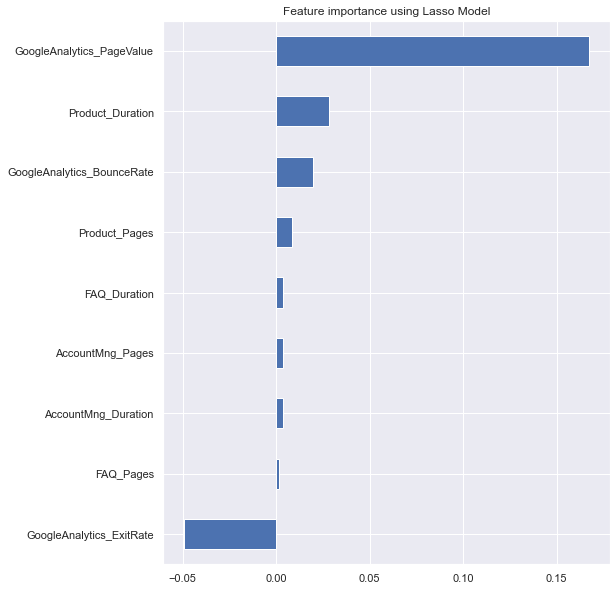

In [32]:
# By calling the function plot_importance() that we created on step 15, plot the feature importance of the variables, 
# by passing as parameters the object coef and the name "Lasso"
plot_importance(coef,'Lasso')

# Chi-Square for categorical data

Create a function named as TestIndependence that should receive as arguments the dataset of independent variables, the target, the name of each independent variable and the alpha defined. This function will follow the steps of chi-square to check if a independent variable is an important predictor.

In [33]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

For all the categorical variables available on `X_cat`, call the function `TestIndependence`.

In [34]:
for var in X_cat:
    TestIndependence(X_cat[var],y, var)

OS is IMPORTANT for Prediction
Browser is IMPORTANT for Prediction
Country is NOT an important predictor. (Discard Country from model)
Type_of_Traffic is IMPORTANT for Prediction
Type_of_Visitor is IMPORTANT for Prediction
Month is IMPORTANT for Prediction
weekday is NOT an important predictor. (Discard weekday from model)


<hr>

### Numerical Data

| Predictor | Spearman | RFE | Lasso | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |--- |
| AccountMng_Pages       | Discard | Discard | Discard | Discard |
| AccountMng_Duration     | Discard | Discard | Discard | Discard |
| FAQ_Pages            | Discard | Keep | Discard | Discard |
| FAQ_Duration          | Discard | Discard | Discard | Discard |
| Product_Pages          | Discard | Keep | Keep | Discard |
| Product_Duration        | Discard | Keep | Keep |  Keep |
| GoogleAnalytics_BounceRate  | Discard | Keep | Keep ? |  Keep | 
| GoogleAnalytics_ExitRate   | Discard | Keep | Keep  |  Keep |
| GoogleAnalytics_PageValue   | Keep | Keep | Keep |  Keep |



<hr>



##### Because there are a lot of zeros in the columns: 
'AccountMng_Pages', 'AccountMng_Duration',  'FAQ_Pages', 'FAQ_Duration', 'Product_Pages', 'Product_Duration'.

We decided to change those columns from numerical to categorical which means all the value 0 will be transform to False and the others above 1 will be transform to True.


In [148]:
dfm_T0 = dfm[['AccountMng_Pages', 'AccountMng_Duration', 'FAQ_Pages', 'FAQ_Duration', 'Product_Pages', 'Product_Duration']]
scaler = Binarizer().fit(dfm_T0)
dfm_T0_scaled = scaler.transform(dfm_T0) # this will return an array
# Convert the array to a pandas dataframe
dfm_T0_scaled = pd.DataFrame(dfm_T0_scaled, columns = dfm_T0.columns).set_index(dfm.index).replace([0,1],[False,True])
dfm = dfm_T0_scaled.join(dfm[['GoogleAnalytics_BounceRate',
       'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'OS',
       'Browser', 'Country', 'Type_of_Traffic', 'Type_of_Visitor', 'Buy',
       'Month', 'weekday']])
dfm

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Browser,Country,Type_of_Traffic,Type_of_Visitor,Buy,Month,weekday
Access_ID,,,,,,,,,,,,,,,,,
102863333,False,False,False,False,False,False,-0.458015,0.478164,-0.317727,MacOSX,b,Portugal,a,Returner,False,March,s
103117814,False,False,False,False,False,False,-0.014060,0.032608,-0.317727,Windows,b,France,f,Returner,False,May,w
103201891,False,False,False,False,False,False,0.053454,0.306482,-0.317727,Windows,d,Italy,a,Returner,False,December,f
103226087,False,False,False,False,False,False,-0.458015,-0.374116,1.956180,Windows,b,United Kingdom,b,Returner,True,December,t
103234445,False,False,True,True,True,True,-0.458015,-0.694998,0.352468,Windows,b,Spain,c,Returner,True,November,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798279589,True,True,True,True,False,False,-0.458015,-0.658209,-0.317727,MacOSX,b,Brazil,n,Returner,False,May,f
798314158,True,True,False,False,False,False,-0.458015,-0.658209,-0.317727,Windows,j,Spain,e,New_Access,False,July,f
798339820,False,False,False,False,False,False,-0.300483,0.175676,-0.317727,MacOSX,b,France,c,Returner,False,March,m


### Redo Chi-Square for categorical data

In [149]:
# Define the independent variables as X and the dependent variable ('Buy') as y.
X = dfm.drop('Buy', axis = 1)
y = dfm['Buy']
X_num = X.select_dtypes(exclude='object').set_index(X.index)
X_cat = X.select_dtypes(include=['object','bool']).set_index(X.index)

In [37]:
for var in X_cat:
    TestIndependence(X_cat[var],y, var)

AccountMng_Pages is IMPORTANT for Prediction
AccountMng_Duration is IMPORTANT for Prediction
FAQ_Pages is IMPORTANT for Prediction
FAQ_Duration is IMPORTANT for Prediction
Product_Pages is IMPORTANT for Prediction
Product_Duration is IMPORTANT for Prediction
OS is IMPORTANT for Prediction
Browser is IMPORTANT for Prediction
Country is NOT an important predictor. (Discard Country from model)
Type_of_Traffic is IMPORTANT for Prediction
Type_of_Visitor is IMPORTANT for Prediction
Month is IMPORTANT for Prediction
weekday is NOT an important predictor. (Discard weekday from model)


<hr>

| Predictor | Spearman | RFE | Lasso | Chi-Square | What to do? (One possible way to "solve") | 
| --- | --- | --- | --- |--- |--- |
| AccountMng_Pages       | Discard | Discard | Discard | Keep |   Discard |
| AccountMng_Duration     | Discard | Discard | Discard | Keep |   Discard |
| FAQ_Pages            | Discard | Keep   | Discard | Keep |     Keep |
| FAQ_Duration          | Discard | Discard | Discard | Keep |   Discard |
| Product_Pages         | Discard | Keep   | Discard | Discard | Discard | 
| Product_Duration       | Discard | Keep   | Discard | Keep |     Keep |

### Categorical Data

| Predictor | Chi-Square | 
| --- | --- | 
| OS  | Keep |  
| Browser | Keep |
| Country  | Discard | 
| Type_of_Visitor  | Keep|
| Month | Keep | 
| weekday  | Discard|

<hr>

### Insights:
The features selected are  'FAQ_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'OS',  'Type_of_Traffic', 'Type_of_Visitor','Month'. The 'FAQ_Pages' and 'Product_Duration' features will be kept like categorical data
######    

In [38]:
dfmf = dfm[['FAQ_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate', 
            'GoogleAnalytics_PageValue', 'OS',  'Type_of_Traffic', 'Type_of_Visitor','Month']]
dfmf_num = dfmf.select_dtypes(include='float64')
scaler = RobustScaler().fit(dfmf_num)
dfmf_num_scaled = scaler.transform(dfmf_num) # this will return an array
# Convert the array to a pandas dataframe
dfmf_num_scaled = pd.DataFrame(dfmf_num_scaled, columns = dfmf_num.columns).set_index(dfmf.index)
dfmf = dfmf_num_scaled.join(dfmf.select_dtypes(exclude='float64')).join(dfm['Buy'])
dfmf

,FAQ_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,OS,Type_of_Traffic,Type_of_Visitor,Month,Buy
Access_ID,,,,,,,,,,
102863333,0.0,-0.419022,-0.188235,1.159664,0.0000,MacOSX,a,Returner,March,False
103117814,0.0,0.072007,1.088235,0.549020,0.0000,Windows,f,Returner,May,False
103201891,0.0,-0.394490,1.282353,0.924370,0.0000,Windows,a,Returner,December,False
103226087,0.0,0.012062,-0.188235,-0.008403,42.4225,Windows,b,Returner,December,True
103234445,2.0,0.804347,-0.188235,-0.448179,12.5033,Windows,c,Returner,November,True
...,...,...,...,...,...,...,...,...,...,...
798279589,2.0,0.400909,-0.188235,-0.397759,0.0000,MacOSX,n,Returner,May,False
798314158,0.0,-0.447827,-0.188235,-0.397759,0.0000,Windows,e,New_Access,July,False
798339820,0.0,0.039957,0.264706,0.745098,0.0000,MacOSX,c,Returner,March,False


# 5. Modelling - Create a predictive model

### Model selection

In [39]:
#Define metric and non-metric features. 
categorical = dfmf.select_dtypes(include='object').columns.to_list()

# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(dfmf[categorical])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=dfmf.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
dfmf = pd.concat([dfmf.drop(columns=categorical), ohc_df], axis=1)

In [65]:
# Read the dataset dfm1 and define the independent variables as X 
# and the dependent variable as y .
X = dfmf.drop(columns='Buy')
y = dfmf['Buy']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=10, stratify=y)

In [39]:
clf = LogisticRegression()

scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for Logistic Regression:",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for Logistic Regression :', f1)

mean validation F1 for Logistic Regression: 0.51 (+/- 0.08)
Test F1 for Logistic Regression : 0.49851632047477745


In [40]:
clf = DecisionTreeClassifier()

scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for Decision Tree Classifier:",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for Decision Tree Classifier :', f1)

mean validation F1 for Decision Tree Classifier: 0.55 (+/- 0.06)
Test F1 for Decision Tree Classifier : 0.5418502202643172


In [41]:
clf = BaggingClassifier()

scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for Random Forests:",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for Random Forests :', f1)

mean validation F1 for Random Forests: 0.60 (+/- 0.06)
Test F1 for Random Forests : 0.5939086294416244


In [42]:
clf = RandomForestClassifier()

scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for Random Forests:",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for Random Forests :', f1)

mean validation F1 for Random Forests: 0.62 (+/- 0.07)
Test F1 for Random Forests : 0.635


In [43]:
clf = MLPClassifier()

scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for neural_network:', f1)

mean validation F1 for neural_network : 0.64 (+/- 0.05)
Test F1 for neural_network: 0.6634844868735084


In [44]:
clf = GaussianNB()

scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for GaussianNB :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for GaussianNB:', f1)

mean validation F1 for GaussianNB : 0.32 (+/- 0.00)
Test F1 for GaussianNB: 0.32202166064981946


In [45]:
clf = GradientBoostingClassifier()
scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for Logistic Regression:",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for Logistic Regression :', f1)

mean validation F1 for Logistic Regression: 0.65 (+/- 0.03)
Test F1 for Logistic Regression : 0.665024630541872


In [46]:
clf = SVC(kernel='linear')
scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for Logistic Regression:",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for Logistic Regression :', f1)

mean validation F1 for Logistic Regression: 0.52 (+/- 0.05)
Test F1 for Logistic Regression : 0.4926686217008798


In [67]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 
print('Original dataset shape %s' % Counter(y_train))
#Original dataset shape Counter({1: 900, 0: 100})
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
#Resampled dataset shape Counter({0: 900, 1: 900})

Original dataset shape Counter({False: 7152, True: 1304})
Resampled dataset shape Counter({False: 7152, True: 7152})


In [68]:
X_train, X_val, y_train, y_val = train_test_split(X_res,y_res, test_size=0.15, random_state=10, stratify=y_res)

In [69]:
lr = LogisticRegression().fit(X_train, y_train)
nb = GaussianNB().fit(X_train, y_train)
kn = KNeighborsClassifier().fit(X_train, y_train)
dt = DecisionTreeClassifier().fit(X_train, y_train)
nn = MLPClassifier().fit(X_train, y_train)
bg = BaggingClassifier().fit(X_train, y_train)
ab = AdaBoostClassifier().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)
gb = GradientBoostingClassifier().fit(X_train, y_train)
svc = SVC(kernel='linear').fit(X_train, y_train)

In [ ]:
accuracies = [f1_score(y_val, lr.predict(X_val)), 
              f1_score(y_val, nb.predict(X_val)), 
              f1_score(y_val, kn.predict(X_val)),
              f1_score(y_val, dt.predict(X_val)), 
              f1_score(y_val, nn.predict(X_val)), 
              f1_score(y_val, bg.predict(X_val)),
              f1_score(y_val, ab.predict(X_val)), 
              f1_score(y_test, rf.predict(X_val)), 
              f1_score(y_val, gb.predict(X_val)),
              f1_score(y_test, svc.predict(X_val))]
models = ['lr','nb','kn','dt','nn','bg','ab','rf','gb','svc']
data_tuples = list(zip(models,accuracies))
data = pd.DataFrame(data_tuples)
data = data.sort_values(1)
plt.bar(data[0], data[1])
plt.ylim(0,1)
plt.show()

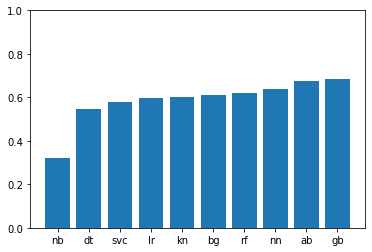

In [61]:
accuracies = [f1_score(y_test, lr.predict(X_test)), 
              f1_score(y_test, nb.predict(X_test)), 
              f1_score(y_test, kn.predict(X_test)),
              f1_score(y_test, dt.predict(X_test)), 
              f1_score(y_test, nn.predict(X_test)), 
              f1_score(y_test, bg.predict(X_test)),
              f1_score(y_test, ab.predict(X_test)), 
              f1_score(y_test, rf.predict(X_test)), 
              f1_score(y_test, gb.predict(X_test)),
              f1_score(y_test, svc.predict(X_test))]
models = ['lr','nb','kn','dt','nn','bg','ab','rf','gb','svc']
data_tuples = list(zip(models,accuracies))
data = pd.DataFrame(data_tuples)
data = data.sort_values(1)
plt.bar(data[0], data[1])
plt.ylim(0,1)
plt.show()

In [21]:
# Create a list of estimators that will contain the four best estimators obtained in the previous step according to the f1 score
estimators = [('gb', GradientBoostingClassifier()),
              ('bg', BaggingClassifier()),
              ('nn', MLPClassifier()),
              ('rf', RandomForestClassifier())]

In [22]:
clf = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier()).fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for Logistic Regression:",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for Logistic Regression :', f1)

mean validation F1 for Logistic Regression: 0.63 (+/- 0.04)
Test F1 for Logistic Regression : 0.6347607052896725


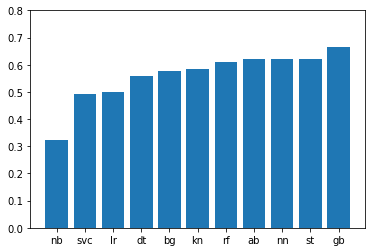

In [23]:
lr = LogisticRegression().fit(X_train, y_train)
nb = GaussianNB().fit(X_train, y_train)
kn = KNeighborsClassifier().fit(X_train, y_train)
dt = DecisionTreeClassifier().fit(X_train, y_train)
nn = MLPClassifier().fit(X_train, y_train)
bg = BaggingClassifier().fit(X_train, y_train)
ab = AdaBoostClassifier().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)
gb = GradientBoostingClassifier().fit(X_train, y_train)
svc = SVC(kernel='linear').fit(X_train, y_train)
st = StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier()).fit(X_train, y_train)
accuracies = [f1_score(y_test, lr.predict(X_test)), 
              f1_score(y_test, nb.predict(X_test)), 
              f1_score(y_test, kn.predict(X_test)),
              f1_score(y_test, dt.predict(X_test)), 
              f1_score(y_test, nn.predict(X_test)), 
              f1_score(y_test, bg.predict(X_test)),
              f1_score(y_test, ab.predict(X_test)), 
              f1_score(y_test, rf.predict(X_test)), 
              f1_score(y_test, gb.predict(X_test)),
              f1_score(y_test, svc.predict(X_test)),
              f1_score(y_test, st.predict(X_test))]
models = ['lr','nb','kn','dt','nn','bg','ab','rf','gb','svc','st']
data_tuples = list(zip(models,accuracies))
data = pd.DataFrame(data_tuples)
data = data.sort_values(1)
plt.bar(data[0], data[1])
plt.ylim(0,0.8)
plt.show()

### Different models were created and the ones with the best F1 score was the  MLP Classifier, the Bagging Classifier, the Random Forest Classifier, and the Gradient Boosting Classifier

#### MLP Classifier

In [57]:
model_lbfgs = MLPClassifier(solver = 'lbfgs')
model_sgd = MLPClassifier(solver = 'sgd')
model_adam = MLPClassifier(solver = 'adam')

In [63]:
for model in [model_lbfgs,model_sgd,model_adam]:

    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(solver='lbfgs') mean validation F1 for neural_network : 0.57 (+/- 0.04)
MLPClassifier(solver='lbfgs') Test F1 for neural_network: 0.5788235294117647
MLPClassifier(solver='sgd') mean validation F1 for neural_network : 0.60 (+/- 0.03)
MLPClassifier(solver='sgd') Test F1 for neural_network: 0.5808080808080808
MLPClassifier() mean validation F1 for neural_network : 0.63 (+/- 0.02)
MLPClassifier() Test F1 for neural_network: 0.6126126126126126


In [64]:
model_lr_big = MLPClassifier(learning_rate_init = 0.5, max_iter = 1000)
model_lr_medium = MLPClassifier(learning_rate_init = 0.001, max_iter = 1000)
model_lr_small = MLPClassifier(learning_rate_init = 0.000001, max_iter = 1000)

In [65]:
for model in [model_lr_big,model_lr_medium,model_lr_small]:

    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(learning_rate_init=0.5, max_iter=1000) mean validation F1 for neural_network : 0.60 (+/- 0.30)
MLPClassifier(learning_rate_init=0.5, max_iter=1000) Test F1 for neural_network: 0.66796875
MLPClassifier(max_iter=1000) mean validation F1 for neural_network : 0.60 (+/- 0.06)
MLPClassifier(max_iter=1000) Test F1 for neural_network: 0.5913461538461537
MLPClassifier(learning_rate_init=1e-06, max_iter=1000) mean validation F1 for neural_network : 0.11 (+/- 0.20)
MLPClassifier(learning_rate_init=1e-06, max_iter=1000) Test F1 for neural_network: 0.25992779783393505


In [66]:
for i in range(500,2501,500):
    model = MLPClassifier(max_iter=i,learning_rate_init=0.5)
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(learning_rate_init=0.5, max_iter=500) mean validation F1 for neural_network : 0.63 (+/- 0.17)
MLPClassifier(learning_rate_init=0.5, max_iter=500) Test F1 for neural_network: 0.3186440677966102
MLPClassifier(learning_rate_init=0.5, max_iter=1000) mean validation F1 for neural_network : 0.62 (+/- 0.18)
MLPClassifier(learning_rate_init=0.5, max_iter=1000) Test F1 for neural_network: 0.40384615384615385
MLPClassifier(learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.54 (+/- 0.32)
MLPClassifier(learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.6704761904761906
MLPClassifier(learning_rate_init=0.5, max_iter=2000) mean validation F1 for neural_network : 0.54 (+/- 0.54)
MLPClassifier(learning_rate_init=0.5, max_iter=2000) Test F1 for neural_network: 0.669260700389105
MLPClassifier(learning_rate_init=0.5, max_iter=2500) mean validation F1 for neural_network : 0.66 (+/- 0.04)
MLPClassifier(learning_rate_init=0.5, max_iter=2500) Test

In [68]:
for i in ['relu','logistic','tanh']:
    model = MLPClassifier(activation=i,learning_rate_init=0.5,max_iter=1500)
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.63 (+/- 0.16)
MLPClassifier(learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.425
MLPClassifier(activation='logistic', learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.65 (+/- 0.06)
MLPClassifier(activation='logistic', learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.6410835214446953
MLPClassifier(activation='tanh', learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.53 (+/- 0.24)
MLPClassifier(activation='tanh', learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.5558441558441559


In [71]:
for i in range(1,20,1):
    model = MLPClassifier(hidden_layer_sizes=i,max_iter=1500,learning_rate_init=0.5, activation='logistic')
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.67 (+/- 0.05)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.6679462571976967
MLPClassifier(activation='logistic', hidden_layer_sizes=2,
              learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.65 (+/- 0.06)
MLPClassifier(activation='logistic', hidden_layer_sizes=2,
              learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.6599597585513077
MLPClassifier(activation='logistic', hidden_layer_sizes=3,
              learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.47 (+/- 0.48)
MLPClassifier(activation='logistic', hidden_layer_sizes=3,
              learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.6177105831533477
MLPClassifier(activ

In [72]:
for i in np.linspace(0.0001, 0.001, num=10):
    model = MLPClassifier(alpha=i,hidden_layer_sizes=1,max_iter=1500,learning_rate_init=0.5, activation='logistic')
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.66 (+/- 0.05)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.6718146718146718
MLPClassifier(activation='logistic', alpha=0.00019999999999999998,
              hidden_layer_sizes=1, learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.67 (+/- 0.04)
MLPClassifier(activation='logistic', alpha=0.00019999999999999998,
              hidden_layer_sizes=1, learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.6641366223908918
MLPClassifier(activation='logistic', alpha=0.0003, hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.40 (+/- 0.65)
MLPClassifier(activation='logistic', alpha=0.0003, hidden_layer_sizes=1,
              learning_rate_ini

In [73]:
for i in [True,False]:
    model = MLPClassifier(shuffle=i,hidden_layer_sizes=1,max_iter=1500,learning_rate_init=0.5, activation='logistic')
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500) mean validation F1 for neural_network : 0.53 (+/- 0.53)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500) Test F1 for neural_network: 0.6557377049180327
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, shuffle=False) mean validation F1 for neural_network : 0.39 (+/- 0.64)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, shuffle=False) Test F1 for neural_network: 0.0


In [74]:
for i in np.linspace(0.1, 1.0, num=10):
    model = MLPClassifier(power_t=i,hidden_layer_sizes=1,max_iter=1500,learning_rate_init=0.5, activation='logistic')
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1) mean validation F1 for neural_network : 0.67 (+/- 0.05)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1) Test F1 for neural_network: 0.6666666666666666
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.2) mean validation F1 for neural_network : 0.66 (+/- 0.07)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.2) Test F1 for neural_network: 0.6717850287907869
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500,
              power_t=0.30000000000000004) mean validation F1 for neural_network : 0.66 (+/- 0.06)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_r

In [75]:
for i in np.linspace(0.1, 1.0, num=10):
    model = MLPClassifier(tol=i,power_t=0.1,hidden_layer_sizes=1,max_iter=1500,learning_rate_init=0.5, activation='logistic')
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1, tol=0.1) mean validation F1 for neural_network : 0.40 (+/- 0.65)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1, tol=0.1) Test F1 for neural_network: 0.6653696498054475
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1, tol=0.2) mean validation F1 for neural_network : 0.53 (+/- 0.53)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1, tol=0.2) Test F1 for neural_network: 0.6679245283018868
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1,
              tol=0.30000000000000004) mean validation F1 for neural_network : 0.67 (+/- 0.04)
MLPClassifier(activation='logistic', h

In [76]:
for i in [True,False]:
    model = MLPClassifier(warm_start=i,tol=1,power_t=0.1,hidden_layer_sizes=1,max_iter=1500,learning_rate_init=0.5, activation='logistic')
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1, tol=1,
              warm_start=True) mean validation F1 for neural_network : 0.66 (+/- 0.05)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1, tol=1,
              warm_start=True) Test F1 for neural_network: 0.6744186046511628
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1, tol=1) mean validation F1 for neural_network : 0.66 (+/- 0.05)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, power_t=0.1, tol=1) Test F1 for neural_network: 0.6731898238747555


In [79]:
for i in np.linspace(0.1, 1.0, num=10):
    for j in [True,False]:
        model = MLPClassifier(momentum =i,nesterovs_momentum = j,warm_start=True,tol=1,power_t=0.1,
                          hidden_layer_sizes=1,max_iter=1500,learning_rate_init=0.5, activation='logistic')
        scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
        print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        model = model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test,y_pred)
        print (str(model),'Test F1 for neural_network:', f1)

MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, momentum=0.1, power_t=0.1,
              tol=1, warm_start=True) mean validation F1 for neural_network : 0.52 (+/- 0.52)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, momentum=0.1, power_t=0.1,
              tol=1, warm_start=True) Test F1 for neural_network: 0.6567164179104478
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, momentum=0.1,
              nesterovs_momentum=False, power_t=0.1, tol=1, warm_start=True) mean validation F1 for neural_network : 0.66 (+/- 0.03)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, momentum=0.1,
              nesterovs_momentum=False, power_t=0.1, tol=1, warm_start=True) Test F1 for neural_network: 0.6731517509727626
MLPClassifier(activation='logistic

MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, nesterovs_momentum=False,
              power_t=0.1, tol=1, warm_start=True) mean validation F1 for neural_network : 0.65 (+/- 0.04)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, nesterovs_momentum=False,
              power_t=0.1, tol=1, warm_start=True) Test F1 for neural_network: 0.6292517006802721
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, momentum=1.0, power_t=0.1,
              tol=1, warm_start=True) mean validation F1 for neural_network : 0.66 (+/- 0.05)
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500, momentum=1.0, power_t=0.1,
              tol=1, warm_start=True) Test F1 for neural_network: 0.6666666666666666
MLPClassifier(activation='logistic', hidden_layer_sizes=1,
   

In [19]:
model_MLP = MLPClassifier(activation='logistic', hidden_layer_sizes=1,
              learning_rate_init=0.5, max_iter=1500,
              momentum=0.3, power_t=0.1, tol=1,
              warm_start=True)
 

In [1]:
models_scores=pd.DataFrame(models_scores).transpose().rename_axis('models').reset_index()
models_scores

NameError: name 'pd' is not defined

In [ ]:
plt.barh(models_scores.models, models_scores.balanced_accuracy)
 
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
 
plt.show()

#### Bagging Classifier

In [81]:
for i in [LogisticRegression(),DecisionTreeClassifier(),KNeighborsClassifier(),GaussianNB()]:
    model = BaggingClassifier(base_estimator=i)
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

BaggingClassifier(base_estimator=LogisticRegression()) mean validation F1 for neural_network : 0.50 (+/- 0.04)
BaggingClassifier(base_estimator=LogisticRegression()) Test F1 for neural_network: 0.47023809523809523
BaggingClassifier(base_estimator=DecisionTreeClassifier()) mean validation F1 for neural_network : 0.59 (+/- 0.04)
BaggingClassifier(base_estimator=DecisionTreeClassifier()) Test F1 for neural_network: 0.548148148148148
BaggingClassifier(base_estimator=KNeighborsClassifier()) mean validation F1 for neural_network : 0.55 (+/- 0.03)
BaggingClassifier(base_estimator=KNeighborsClassifier()) Test F1 for neural_network: 0.5354330708661418
BaggingClassifier(base_estimator=GaussianNB()) mean validation F1 for neural_network : 0.30 (+/- 0.01)
BaggingClassifier(base_estimator=GaussianNB()) Test F1 for neural_network: 0.30376344086021506


In [82]:
for i in [2,5,10,20,30,50,100,150,200]:
    for j in range(0,31,10):
        model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=i,random_state=j)
        scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
        print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        model = model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test,y_pred)
        print (str(model),'Test F1 for neural_network:', f1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=2,
                  random_state=0) mean validation F1 for neural_network : 0.49 (+/- 0.06)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=2,
                  random_state=0) Test F1 for neural_network: 0.46961325966850825
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=2,
                  random_state=10) mean validation F1 for neural_network : 0.50 (+/- 0.04)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=2,
                  random_state=10) Test F1 for neural_network: 0.4973544973544973
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=2,
                  random_state=20) mean validation F1 for neural_network : 0.48 (+/- 0.04)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=2,
                  random_state=20) Test F1 for neural_network: 0.37572254335260113
BaggingClassifier(base_estimato

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=20) Test F1 for neural_network: 0.5776699029126213
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=30) mean validation F1 for neural_network : 0.62 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=30) Test F1 for neural_network: 0.5686274509803922
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=150,
                  random_state=0) mean validation F1 for neural_network : 0.63 (+/- 0.04)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=150,
                  random_state=0) Test F1 for neural_network: 0.5819070904645477
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=150,
                  random_state=10) mean validation F1 for neural_network : 0.63 (+/- 0.04)
BaggingClassifier(bas

In [83]:
for i in  np.linspace(0.1, 1.0, num=10):
    model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20,max_samples=i)
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.1,
                  n_estimators=200, random_state=20) mean validation F1 for neural_network : 0.64 (+/- 0.02)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.1,
                  n_estimators=200, random_state=20) Test F1 for neural_network: 0.6195121951219513
BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.2,
                  n_estimators=200, random_state=20) mean validation F1 for neural_network : 0.64 (+/- 0.03)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.2,
                  n_estimators=200, random_state=20) Test F1 for neural_network: 0.6004962779156328
BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                  max_samples=0.30000000000000004, n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.64 (+/- 0.02)
BaggingClassifier(base_estimator=DecisionTreeClassifier(),


In [84]:
for i in  np.linspace(0.1, 1.0, num=10):
    BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.4,
                  n_estimators=200, random_state=20,bootstrap=i)
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.63 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) Test F1 for neural_network: 0.5853658536585366
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.63 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) Test F1 for neural_network: 0.5853658536585366
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.63 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) Test F1 for neural_network: 0.5853658536585366
BaggingClassifier(b

In [85]:
for i in  [True,False]:
    for j in [None,1,2,3,-1]:
        BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.4,
                  n_estimators=200, random_state=20,warm_start=i,n_jobs=j)
        scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
        print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        model = model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test,y_pred)
        print (str(model),'Test F1 for neural_network:', f1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.63 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) Test F1 for neural_network: 0.5853658536585366
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.63 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) Test F1 for neural_network: 0.5853658536585366
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.63 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) Test F1 for neural_network: 0.5853658536585366
BaggingClassifier(b

In [86]:
for i in range(0,11,1):
    BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.4,
                  n_estimators=200, random_state=20,verbose=i)
    scores = cross_val_score(model, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
    print (str(model),"mean validation F1 for neural_network :",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    model = model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test,y_pred)
    print (str(model),'Test F1 for neural_network:', f1)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.63 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) Test F1 for neural_network: 0.5853658536585366
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.63 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) Test F1 for neural_network: 0.5853658536585366
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) mean validation F1 for neural_network : 0.63 (+/- 0.05)
BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=200,
                  random_state=20) Test F1 for neural_network: 0.5853658536585366
BaggingClassifier(b

In [20]:
model_Bag =  BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.4,
                  n_estimators=200, random_state=20)

#### Random Forest Classifier

In [88]:
parameter_space = {'random_state':[10,15,20,30,40,80,100]}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'random_state': 20}
------------------------------------------------------------------------------------------------------------------------
0.623 (+/-0.009) for {'random_state': 10}
0.622 (+/-0.011) for {'random_state': 15}
0.628 (+/-0.019) for {'random_state': 20}
0.620 (+/-0.009) for {'random_state': 30}
0.621 (+/-0.010) for {'random_state': 40}
0.625 (+/-0.011) for {'random_state': 80}
0.617 (+/-0.010) for {'random_state': 100}


In [89]:
parameter_space = {'n_estimators':[10,20,40,80,160,200,300,500,700,1000]}
rf = RandomForestClassifier(random_state=20)
clf = GridSearchCV(rf, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'n_estimators': 700}
------------------------------------------------------------------------------------------------------------------------
0.592 (+/-0.008) for {'n_estimators': 10}
0.615 (+/-0.004) for {'n_estimators': 20}
0.621 (+/-0.023) for {'n_estimators': 40}
0.626 (+/-0.019) for {'n_estimators': 80}
0.627 (+/-0.011) for {'n_estimators': 160}
0.626 (+/-0.009) for {'n_estimators': 200}
0.625 (+/-0.011) for {'n_estimators': 300}
0.626 (+/-0.012) for {'n_estimators': 500}
0.630 (+/-0.012) for {'n_estimators': 700}
0.628 (+/-0.012) for {'n_estimators': 1000}


In [90]:
parameter_space = {'bootstrap':[True,False]}
rf = RandomForestClassifier(random_state=20,n_estimators=700)
clf = GridSearchCV(rf, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'bootstrap': True}
------------------------------------------------------------------------------------------------------------------------
0.630 (+/-0.012) for {'bootstrap': True}
0.612 (+/-0.014) for {'bootstrap': False}


In [91]:
parameter_space = {'max_samples':[0.1,0.2,0.4,0.6,0.8,1.0]}
rf = RandomForestClassifier(random_state=20,n_estimators=700,bootstrap=True)
clf = GridSearchCV(rf, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'max_samples': 0.4}
------------------------------------------------------------------------------------------------------------------------
0.625 (+/-0.008) for {'max_samples': 0.1}
0.628 (+/-0.010) for {'max_samples': 0.2}
0.633 (+/-0.010) for {'max_samples': 0.4}
0.629 (+/-0.010) for {'max_samples': 0.6}
0.625 (+/-0.012) for {'max_samples': 0.8}
nan (+/-nan) for {'max_samples': 1.0}


In [92]:
parameter_space = {'max_depth':[1,2,4,6,8,10,12,14,16,None]}
rf = RandomForestClassifier(random_state=20,n_estimators=700,bootstrap=True,max_samples=0.4)
clf = GridSearchCV(rf, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'max_depth': 14}
------------------------------------------------------------------------------------------------------------------------
0.000 (+/-0.000) for {'max_depth': 1}
0.000 (+/-0.000) for {'max_depth': 2}
0.164 (+/-0.055) for {'max_depth': 4}
0.547 (+/-0.015) for {'max_depth': 6}
0.609 (+/-0.010) for {'max_depth': 8}
0.625 (+/-0.008) for {'max_depth': 10}
0.634 (+/-0.010) for {'max_depth': 12}
0.636 (+/-0.009) for {'max_depth': 14}
0.629 (+/-0.009) for {'max_depth': 16}
0.633 (+/-0.010) for {'max_depth': None}


In [93]:
parameter_space = {'min_weight_fraction_leaf':[0.1,0.2,0.3,0.4,0.5]
                  , 'min_samples_split':[2,4,6,8,10,None]}
rf = RandomForestClassifier(random_state=20,n_estimators=700,bootstrap=True,max_samples=0.4,max_depth=16)
clf = GridSearchCV(rf, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1}
------------------------------------------------------------------------------------------------------------------------
0.000 (+/-0.000) for {'min_samples_split': 2, 'min_weight_fraction_leaf': 0.1}
0.000 (+/-0.000) for {'min_samples_split': 2, 'min_weight_fraction_leaf': 0.2}
0.000 (+/-0.000) for {'min_samples_split': 2, 'min_weight_fraction_leaf': 0.3}
0.000 (+/-0.000) for {'min_samples_split': 2, 'min_weight_fraction_leaf': 0.4}
0.000 (+/-0.000) for {'min_samples_split': 2, 'min_weight_fraction_leaf': 0.5}
0.000 (+/-0.000) for {'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1}
0.000 (+/-0.000) for {'min_samples_split': 4, 'min_weight_fraction_leaf': 0.2}
0.000 (+/-0.000) for {'min_samples_split': 4, 'min_weight_fraction_leaf': 0.3}
0.000 (+/-0.000) for {'min_samples_split': 4

In [21]:
model_rf=RandomForestClassifier(random_state=20,n_estimators=700,bootstrap=True,max_samples=0.4,
                                max_depth=16)

In [90]:
GradientBoostingClassifierdientBoostingClassifier?feature_importances_ 

#### Gradient Boosting Classifier

In [186]:
dfmf2=dfm.copy()

dfmf2_num = dfmf2.select_dtypes(exclude=['object','bool']).set_index(dfmf2.index)
scaler = StandardScaler().fit(dfmf2_num)
dfmf2_num_scaled = scaler.transform(dfmf2_num) # this will return an array
# Convert the array to a pandas dataframe
dfmf2_num_scaled = pd.DataFrame(dfmf2_num_scaled, columns = dfmf2_num.columns).set_index(dfmf2.index)
dfmf2 = dfmf2_num_scaled.join(dfmf2.select_dtypes(include='object').set_index(dfmf2.index))

#Define metric and non-metric features. 
categorical = dfmf2.select_dtypes(include="object").columns.to_list()
numerical = dfmf2.columns.drop(categorical).to_list()

# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(dfmf2[categorical])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=dfmf2.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
dfmf2 = pd.concat([dfmf2.drop(columns=categorical), ohc_df,dfm['Buy']], axis=1)
dfmf2

TypeError: 'RobustScaler' object is not callable

In [177]:
# Read the dataset dfmf2 and define the independent variables as X 
# and the dependent variable as y .
X = dfmf2.drop(columns='Buy')
y = dfmf2['Buy']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=42, stratify=y)

In [178]:
clf = GradientBoostingClassifier()

scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for Decision Tree Classifier:",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for Decision Tree Classifier :', f1)

mean validation F1 for Decision Tree Classifier: 0.67 (+/- 0.04)
Test F1 for Decision Tree Classifier : 0.6348448687350835


<AxesSubplot:xlabel='Value', ylabel='Col'>

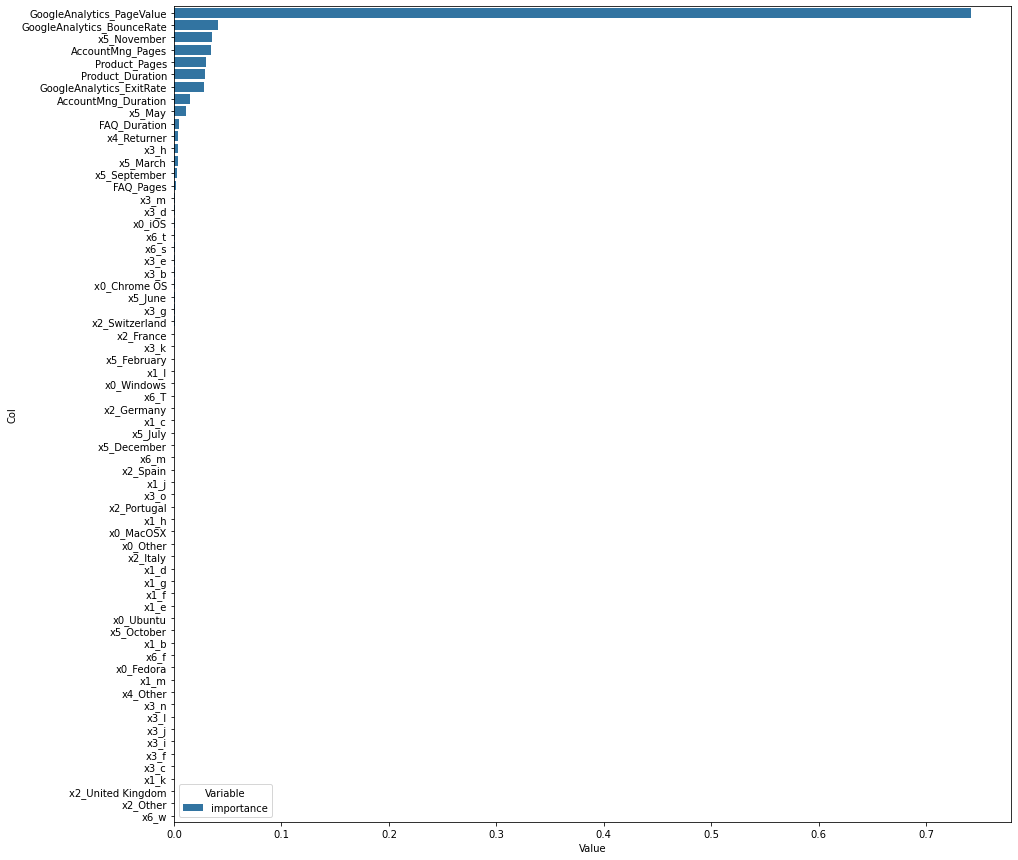

In [179]:
feature_importances = GradientBoostingClassifier().fit(X_train, y_train).feature_importances_
zippy = pd.DataFrame(zip(feature_importances), columns = ['importance'])
zippy['col'] = X_train.columns
tidy = zippy.melt(id_vars='col').rename(columns=str.title)
tidy.sort_values(['Value'], ascending = False, inplace = True)

plt.figure(figsize=(15,15))
sns.barplot(y='Col', x='Value', hue='Variable', data=tidy)

In [148]:
parameter_space = {'learning_rate':[0.01,0.02,0.05,0.1,0.15,0.2]}
gb =GradientBoostingClassifier()
clf = GridSearchCV(gb, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('a------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

a------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'learning_rate': 0.1}
------------------------------------------------------------------------------------------------------------------------
0.479 (+/-0.022) for {'learning_rate': 0.01}
0.615 (+/-0.008) for {'learning_rate': 0.02}
0.655 (+/-0.022) for {'learning_rate': 0.05}
0.663 (+/-0.021) for {'learning_rate': 0.1}
0.655 (+/-0.012) for {'learning_rate': 0.15}
0.654 (+/-0.011) for {'learning_rate': 0.2}


In [150]:
parameter_space = {'n_estimators':range(20,201,10)}
gb = GradientBoostingClassifier(learning_rate=0.1,
                                min_samples_leaf=5,max_features='sqrt',subsample=0.8,random_state=10)
clf = GridSearchCV(gb, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'n_estimators': 150}
------------------------------------------------------------------------------------------------------------------------
0.579 (+/-0.073) for {'n_estimators': 20}
0.647 (+/-0.030) for {'n_estimators': 30}
0.655 (+/-0.026) for {'n_estimators': 40}
0.662 (+/-0.027) for {'n_estimators': 50}
0.662 (+/-0.029) for {'n_estimators': 60}
0.660 (+/-0.032) for {'n_estimators': 70}
0.661 (+/-0.031) for {'n_estimators': 80}
0.662 (+/-0.026) for {'n_estimators': 90}
0.661 (+/-0.026) for {'n_estimators': 100}
0.659 (+/-0.023) for {'n_estimators': 110}
0.658 (+/-0.023) for {'n_estimators': 120}
0.659 (+/-0.025) for {'n_estimators': 130}
0.662 (+/-0.027) for {'n_estimators': 140}
0.663 (+/-0.023) for {'n_estimators': 150}
0.657 (+/-0.024) for {'n_estimators': 160}
0.656 (+/-0.021) for {'n_estimators': 170}
0.656 (+/-0.023) for {'n_estimat

In [151]:
parameter_space = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gb = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,
                                min_samples_leaf=5,max_features='sqrt',subsample=0.8,random_state=10)
clf = GridSearchCV(gb, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'max_depth': 11, 'min_samples_split': 800}
------------------------------------------------------------------------------------------------------------------------
0.657 (+/-0.017) for {'max_depth': 5, 'min_samples_split': 200}
0.660 (+/-0.024) for {'max_depth': 5, 'min_samples_split': 400}
0.659 (+/-0.016) for {'max_depth': 5, 'min_samples_split': 600}
0.658 (+/-0.020) for {'max_depth': 5, 'min_samples_split': 800}
0.655 (+/-0.025) for {'max_depth': 5, 'min_samples_split': 1000}
0.655 (+/-0.013) for {'max_depth': 7, 'min_samples_split': 200}
0.656 (+/-0.020) for {'max_depth': 7, 'min_samples_split': 400}
0.661 (+/-0.021) for {'max_depth': 7, 'min_samples_split': 600}
0.662 (+/-0.013) for {'max_depth': 7, 'min_samples_split': 800}
0.656 (+/-0.014) for {'max_depth': 7, 'min_samples_split': 1000}
0.651 (+/-0.018) for {'max_depth': 9, 'min_sampl

In [154]:
parameter_space = {'min_samples_leaf':range(30,151,10)}
gb = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,min_samples_split=800,
                                max_depth=11,max_features='sqrt',subsample=0.8,random_state=10)
clf = GridSearchCV(gb, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'min_samples_leaf': 70}
------------------------------------------------------------------------------------------------------------------------
0.656 (+/-0.019) for {'min_samples_leaf': 30}
0.666 (+/-0.023) for {'min_samples_leaf': 40}
0.659 (+/-0.026) for {'min_samples_leaf': 50}
0.660 (+/-0.024) for {'min_samples_leaf': 60}
0.672 (+/-0.020) for {'min_samples_leaf': 70}
0.662 (+/-0.019) for {'min_samples_leaf': 80}
0.661 (+/-0.016) for {'min_samples_leaf': 90}
0.666 (+/-0.022) for {'min_samples_leaf': 100}
0.665 (+/-0.023) for {'min_samples_leaf': 110}
0.667 (+/-0.016) for {'min_samples_leaf': 120}
0.664 (+/-0.027) for {'min_samples_leaf': 130}
0.663 (+/-0.026) for {'min_samples_leaf': 140}
0.658 (+/-0.022) for {'min_samples_leaf': 150}


In [156]:
parameter_space = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gb = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,min_samples_split=800,
                                max_depth=11,max_features='sqrt',min_samples_leaf=70,random_state=10)
clf = GridSearchCV(gb, parameter_space, scoring = 'f1')
clf.fit(X_train, y_train)
# Best parameter set
print('------------------------------------------------------------------------------------------------------------------------')
print('Best parameters found:\n', clf.best_params_)
print('------------------------------------------------------------------------------------------------------------------------')

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

------------------------------------------------------------------------------------------------------------------------
Best parameters found:
 {'subsample': 0.8}
------------------------------------------------------------------------------------------------------------------------
0.664 (+/-0.022) for {'subsample': 0.6}
0.666 (+/-0.017) for {'subsample': 0.7}
0.668 (+/-0.021) for {'subsample': 0.75}
0.672 (+/-0.020) for {'subsample': 0.8}
0.666 (+/-0.018) for {'subsample': 0.85}
0.669 (+/-0.018) for {'subsample': 0.9}


In [161]:
model_gb = GradientBoostingClassifier(learning_rate=0.1,n_estimators=150,min_samples_split=800,
                                max_depth=11,max_features='sqrt',min_samples_leaf=70,random_state=10,subsample=0.8)

In [163]:
clf = model_gb

scores = cross_val_score(clf, X_train, y_train.ravel(),
                         cv=5, scoring = 'f1')
print ("mean validation F1 for Decision Tree Classifier:",
       "%0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
clf = clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
f1 = f1_score(y_test,y_pred)
print ('Test F1 for Decision Tree Classifier :', f1)

mean validation F1 for Decision Tree Classifier: 0.67 (+/- 0.04)
Test F1 for Decision Tree Classifier : 0.6287128712871288


# 6. Assessment

In [27]:
nn = model_MLP.fit(X_train, y_train)
bg = model_Bag.fit(X_train, y_train)
rf = model_rf.fit(X_train, y_train)
gb = model_gb.fit(X_train, y_train)

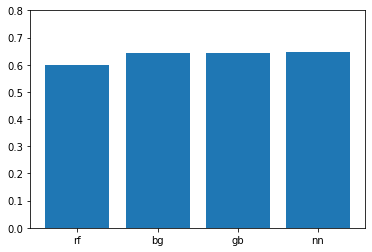

In [28]:
accuracies = [f1_score(y_test, nn.predict(X_test)), 
              f1_score(y_test, bg.predict(X_test)),
              f1_score(y_test, rf.predict(X_test)), 
              f1_score(y_test, gb.predict(X_test))]
models = ['nn','bg','rf','gb']
data_tuples = list(zip(models,accuracies))
data = pd.DataFrame(data_tuples)
data = data.sort_values(1)
plt.bar(data[0], data[1])
plt.ylim(0,0.8)
plt.show()

In [29]:
# Create a list of estimators that will contain the four best estimators obtained in the previous step according to the f1 score
estimators = [('gb', model_gb),
              ('bg', model_Bag),
              ('nn', model_MLP),
              ('rf', model_rf)]

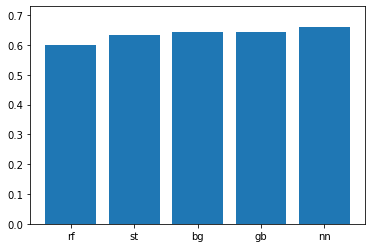

In [30]:
nn = model_MLP.fit(X_train, y_train)
bg = model_Bag.fit(X_train, y_train)
rf = model_rf.fit(X_train, y_train)
gb = model_gb.fit(X_train, y_train)
st = StackingClassifier(estimators=estimators, final_estimator=model_gb).fit(X_train, y_train)
accuracies = [f1_score(y_test, nn.predict(X_test)), 
              f1_score(y_test, bg.predict(X_test)), 
              f1_score(y_test, rf.predict(X_test)), 
              f1_score(y_test, gb.predict(X_test)),
              f1_score(y_test, st.predict(X_test))]
models = ['nn','bg','rf','gb','st']
data_tuples = list(zip(models,accuracies))
data = pd.DataFrame(data_tuples)
data = data.sort_values(1)
plt.bar(data[0], data[1])
plt.ylim(0,0.73)
plt.show()

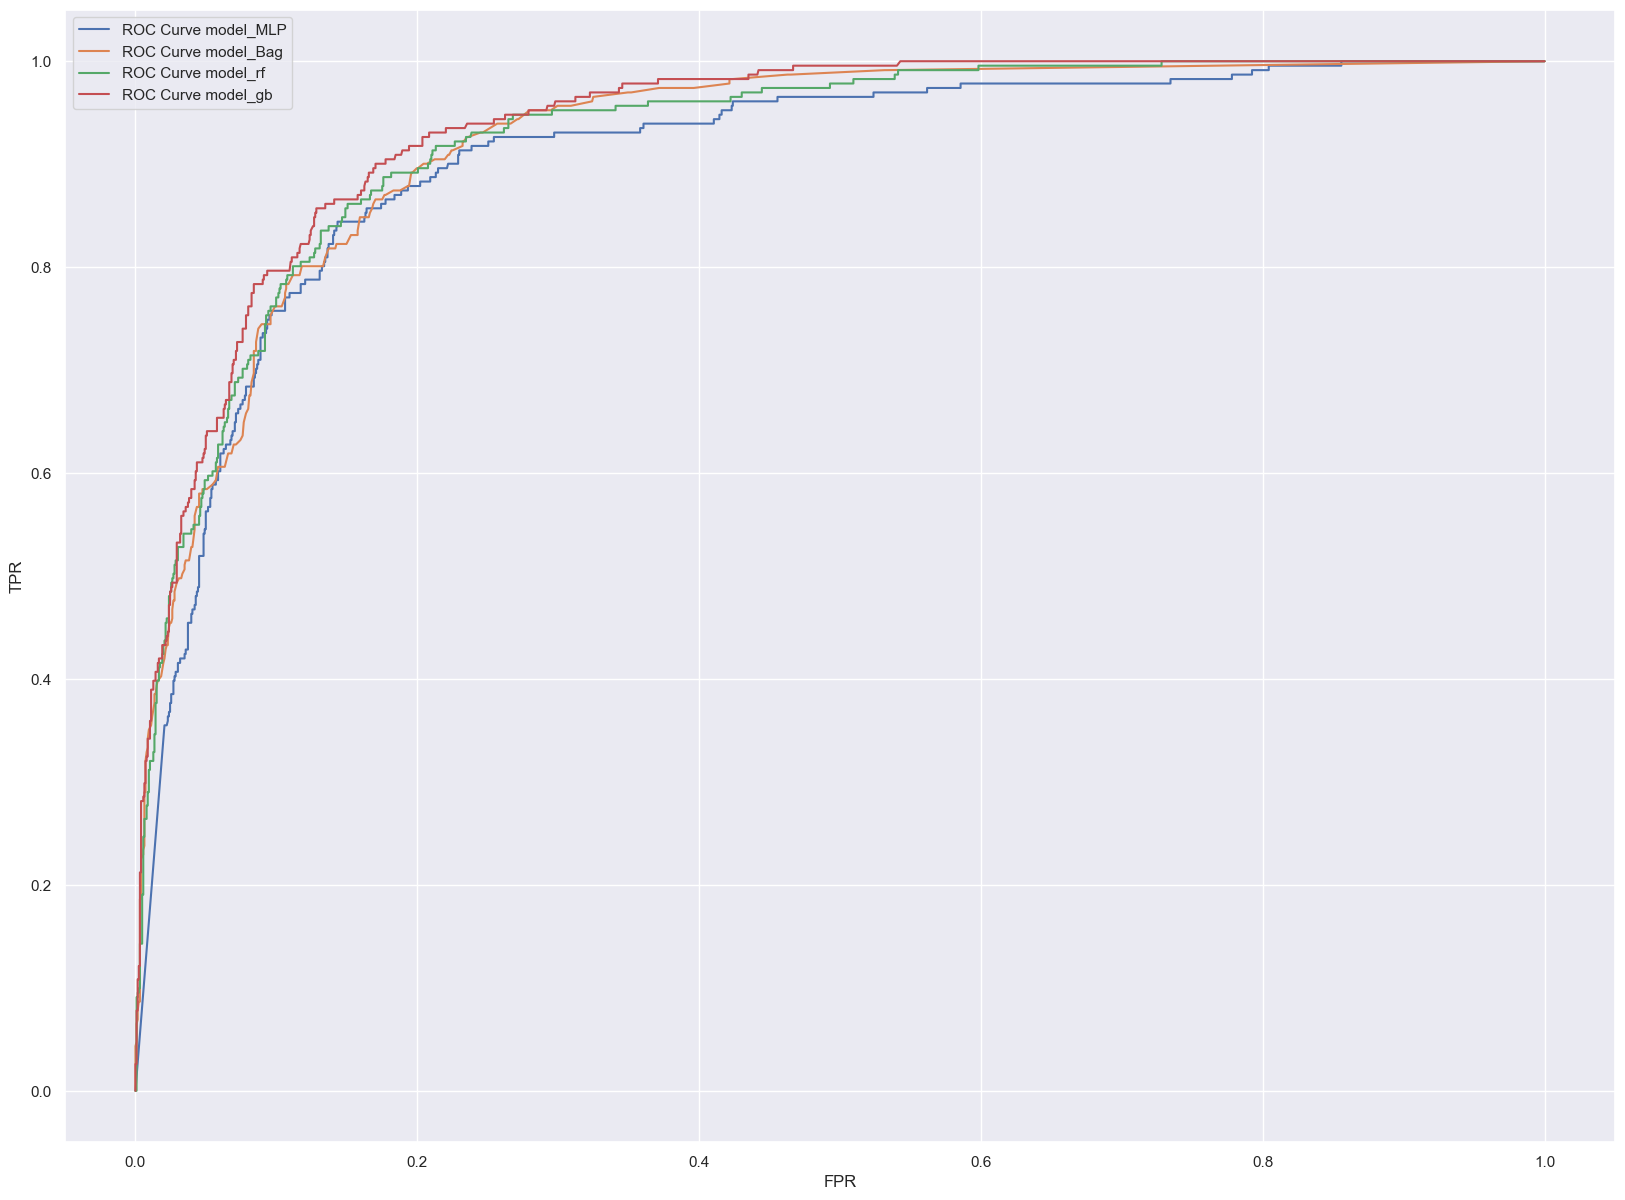

In [162]:
model_MLP = model_MLP.fit(X_train, y_train)
model_Bag = model_Bag.fit(X_train, y_train)
model_rf = model_rf.fit(X_train, y_train)
model_gb = model_gb.fit(X_train, y_train)


prob_model_MLP = model_MLP.predict_proba(X_test)
prob_model_Bag = model_Bag.predict_proba(X_test)
prob_model_rf = model_rf.predict_proba(X_test)
prob_model_gb = model_gb.predict_proba(X_test)


fpr_MLP, tpr_MLP, thresholds_MLP = roc_curve(y_test, prob_model_MLP[:,1])
fpr_Bag, tpr_Bag, thresholds_Bag = roc_curve(y_test, prob_model_Bag[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, prob_model_rf[:,1])
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, prob_model_gb[:,1])


plt.figure(figsize=(20, 15), dpi=100)
plt.plot(fpr_MLP, tpr_MLP,label="ROC Curve model_MLP")
plt.plot(fpr_Bag, tpr_Bag, label="ROC Curve model_Bag")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve model_rf")
plt.plot(fpr_gb, tpr_gb, label="ROC Curve model_gb")

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

#### From analysing the ROC curve and besic on the f1 score plot that we will use  GradientBoostingClassifier to make the final prediction

In [165]:
model= model_gb
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1

0.6287128712871288

##### We will now import our test dataset and predicte on unseen data. For this we will recreate all the actions taken that led to our final model and best score. The stacked model will also be created and fitted to new dataset.

In [166]:
#import the data from test to test our model
Train = pd.read_csv("train.csv")

#modifying the test data
#change the date to panda datetime
Train["Date"]= pd.to_datetime(Train["Date"])

#set the index
Train.set_index("Access_ID",inplace=True)

#creat Month column and drop the Date Column
Train["Month"] = Train["Date"].dt.month_name().drop(columns="Date")
Train['Buy'] = Train['Buy'].replace([0,1],[False,True])
Train['Type_of_Traffic'] = Train['Type_of_Traffic'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o'])

#select the features
Train = Train[['FAQ_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate', 
            'GoogleAnalytics_PageValue', 'OS', 'Type_of_Traffic', 'Type_of_Visitor','Month', 'Buy']]

Train_T0 = Train[['FAQ_Pages', 'Product_Duration']]
Binarizer_scaler = Binarizer().fit(Train_T0)
Train_T0_scaled = Binarizer_scaler.transform(Train_T0) # this will return an array
# Convert the array to a pandas dataframe
Train_T0_scaled = pd.DataFrame(Train_T0_scaled, columns = Train_T0.columns).set_index(Train.index).replace([0,1],[False,True])
Train = Train_T0_scaled.join(Train[['GoogleAnalytics_BounceRate',
       'GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue', 'OS',
       'Type_of_Traffic', 'Type_of_Visitor',
       'Month','Buy']])


Train_num = Train[['GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate', 
            'GoogleAnalytics_PageValue']]
#scaler from before
TScaler=RobustScaler().fit(Train_num)
Train_num_scaled = StandardScaler.transform(Train_num) # this will return an array
# Convert the array to a pandas dataframe
Train_num_scaled = pd.DataFrame(Train_num_scaled, columns = Train_num.columns).set_index(Train.index)
Train = Train_num_scaled.join(Train[['FAQ_Pages', 'Product_Duration', 'OS', 'Type_of_Traffic', 
                                     'Type_of_Visitor','Month', 'Buy']].set_index(Train.index))


# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(Train[['OS', 'Type_of_Traffic', 'Type_of_Visitor','Month']])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=Train.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
Train = pd.concat([Train[['FAQ_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate', 
            'GoogleAnalytics_PageValue', 'Buy']], ohc_df], axis=1)
Train

,FAQ_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Buy,x0_Chrome OS,x0_Fedora,x0_MacOSX,x0_Other,...,x2_Returner,x3_December,x3_February,x3_July,x3_June,x3_March,x3_May,x3_November,x3_October,x3_September
Access_ID,,,,,,,,,,,,,,,,,,,,,
102863333,False,True,-0.190476,1.165266,0.0000,False,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
103117814,False,True,1.101190,0.554622,0.0000,False,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
103201891,False,True,1.297619,0.929972,0.0000,False,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103226087,False,True,-0.190476,-0.002801,42.4225,True,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103234445,True,True,-0.190476,-0.442577,12.5033,True,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798279589,True,True,-0.190476,-0.392157,0.0000,False,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
798314158,False,True,-0.190476,-0.392157,0.0000,False,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
798339820,False,True,0.267857,0.750700,0.0000,False,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [167]:
# Read the dataset dfm1 and define the independent variables as X 
# and the dependent variable as y .
X_train = Train.drop(columns='Buy')
y_train = Train['Buy']

# create an instance
model = model_gb

#Fit the model to the train data
model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=11, max_features='sqrt',
                           min_samples_leaf=70, min_samples_split=800,
                           n_estimators=150, random_state=10, subsample=0.8)

In [168]:
#import the data from test to test our model
df_test = pd.read_csv("test.csv")

#modifying the test data
#change the date to panda datetime
df_test["Date"]= pd.to_datetime(df_test["Date"])

#set the index
df_test.set_index("Access_ID",inplace=True)

#creat Month column and drop the Date Column
df_test["Month"] = df_test["Date"].dt.month_name().drop(columns="Date")
df_test['Type_of_Traffic'] = df_test['Type_of_Traffic'].replace([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o'])
#select the features
df_test = df_test[['FAQ_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate', 
            'GoogleAnalytics_PageValue', 'OS',  'Type_of_Traffic', 'Type_of_Visitor','Month']]

df_test_T0 = df_test[['FAQ_Pages', 'Product_Duration']]
Binarizer_scaler=Binarizer()
df_test_T0_scaled = Binarizer_scaler.transform(df_test_T0) # this will return an array
# Convert the array to a pandas dataframe
df_test_T0_scaled = pd.DataFrame(df_test_T0_scaled, columns = df_test_T0.columns).set_index(df_test.index).replace([0,1],[False,True])
df_test = df_test_T0_scaled.join(df_test[['GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate', 'GoogleAnalytics_PageValue',
                                          'OS', 'Type_of_Traffic', 'Type_of_Visitor', 'Month']])


df_test_num = df_test[['GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate', 
            'GoogleAnalytics_PageValue']]
#scaler from before

df_test_num_scaled = TScaler.transform(df_test_num) # this will return an array
# Convert the array to a pandas dataframe
df_test_num_scaled = pd.DataFrame(df_test_num_scaled, columns = df_test_num.columns).set_index(df_test.index)
df_test = df_test_num_scaled.join(df_test[['FAQ_Pages', 'Product_Duration', 'OS', 'Type_of_Traffic', 
                                     'Type_of_Visitor','Month']].set_index(df_test.index))


# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_test[['OS', 'Type_of_Traffic', 'Type_of_Visitor','Month']])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_test.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
# Reassigning df to contain ohc variables
df_test = pd.concat([df_test[['FAQ_Pages', 'Product_Duration', 'GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate', 
            'GoogleAnalytics_PageValue']], ohc_df], axis=1)
df_test

,FAQ_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,x0_Chrome OS,x0_Fedora,x0_MacOSX,x0_Other,x0_Ubuntu,...,x2_Returner,x3_December,x3_February,x3_July,x3_June,x3_March,x3_May,x3_November,x3_October,x3_September
Access_ID,,,,,,,,,,,,,,,,,,,,,
798519314,False,True,0.636905,1.128852,0.0000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
798663101,False,True,-0.119048,-0.540616,0.0000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
798663221,False,True,-0.190476,-0.002801,0.0000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
798760918,False,True,-0.190476,2.098039,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
798856982,True,True,-0.107143,-0.184874,1.0353,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962042726,True,True,0.095238,-0.084034,0.0000,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
962063064,False,True,3.779762,2.098039,0.0000,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
962147749,False,True,-0.190476,-0.002801,9.6503,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [169]:
# predict our test data and show
y_pred = model.predict(df_test)
y_pred=pd.DataFrame(y_pred)
y_pred.rename(columns={0: 'Buy'}, inplace=True)
y_pred

,Buy
0,False
1,False
2,False
3,False
4,True
...,...
2295,False
2296,False
2297,True
2298,False


In [170]:
# join the prediction in the data and get the result
df_test=df_test.reset_index()
df_test=df_test.join(y_pred)
df_test

,Access_ID,FAQ_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,x0_Chrome OS,x0_Fedora,x0_MacOSX,x0_Other,...,x3_December,x3_February,x3_July,x3_June,x3_March,x3_May,x3_November,x3_October,x3_September,Buy
0,798519314,False,True,0.636905,1.128852,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,798663101,False,True,-0.119048,-0.540616,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False
2,798663221,False,True,-0.190476,-0.002801,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
3,798760918,False,True,-0.190476,2.098039,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False
4,798856982,True,True,-0.107143,-0.184874,1.0353,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,962042726,True,True,0.095238,-0.084034,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
2296,962063064,False,True,3.779762,2.098039,0.0000,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
2297,962147749,False,True,-0.190476,-0.002801,9.6503,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
2298,962182167,False,True,0.803571,0.697479,0.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False


#### Submission Sample for Kaggle

In [171]:
result = df_test[['Access_ID','Buy']]
result

,Access_ID,Buy
0,798519314,False
1,798663101,False
2,798663221,False
3,798760918,False
4,798856982,True
...,...,...
2295,962042726,False
2296,962063064,False
2297,962147749,True
2298,962182167,False


In [172]:
result.to_csv('submission.csv' , index=False)